In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from typing import Union, List, Optional
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from torchhd.embeddings import Projection
from torchhd.models import Centroid

In [2]:
class PTBXL_Dataset(Dataset):
    """
    A PyTorch Dataset for ECG samples grouped by subject (PTB-XL).

    Args:
        data_path (str): Path to the .pt file with data grouped by subject.
        subject_ids (Union[float, List[float], None]): Subject(s) to include. If None, uses all subjects.
        split (str): 'train', 'test', or None — whether to return a subset.
        test_ratio (float): Proportion to reserve for test split (if split is specified).
        random_seed (int): Random seed for reproducibility.
    """
    def __init__(
        self,
        data_path: str,
        subject_ids: Optional[Union[float, List[float]]] = None,
        split: Optional[str] = None,
        test_ratio: float = 0.2,
        val_ratio: float = 0.2,
        random_seed: int = 42
    ):
        assert split in [None, 'train', 'val', 'test'], "split must be None, 'train', 'val', or 'test'"

        raw_data = torch.load(data_path)
        all_subject_data = raw_data['data_by_subject']
        self.label_encoder = raw_data['label_encoder']
        # label index: [0:'AFIB' 1:'NORM' 2:'PAC' 3:'PVC' 4:'SBRAD' 5:'STACH']

        # Normalize subject_ids to list
        if subject_ids is None:
            selected_subjects = list(all_subject_data.keys())
        elif isinstance(subject_ids, float):
            selected_subjects = [subject_ids]
        else:
            selected_subjects = subject_ids

        # Collect all (x, y) pairs per subject
        all_samples = []

        for sid in selected_subjects:
            subject_data = all_subject_data[sid]
            x_list = subject_data['x']
            y_list = subject_data['y']
            samples = list(zip(x_list, y_list))
            all_samples.extend(samples)

        # Split based on sample count
        if split is not None:
            stratify_labels = [int(y) for _, y in all_samples]

            # First split into temp (train+val) and test
            temp_idx, test_idx = train_test_split(
                range(len(all_samples)),
                test_size=test_ratio,
                random_state=random_seed,
                stratify=stratify_labels
            )

            temp_samples = [all_samples[i] for i in temp_idx]
            temp_labels = [int(y) for _, y in temp_samples]

            # Now split temp into train and val
            train_idx, val_idx = train_test_split(
                range(len(temp_samples)),
                test_size=val_ratio,
                random_state=random_seed,
                stratify=temp_labels
            )

            if split == 'train':
                indices = [temp_idx[i] for i in train_idx]
            elif split == 'val':
                indices = [temp_idx[i] for i in val_idx]
            elif split == 'test':
                indices = test_idx

            self.samples = [all_samples[i] for i in indices]
        else:
            self.samples = all_samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        x, y = self.samples[idx]
        return x.unsqueeze(0), y  # Add channel dimension: (1, 2500)


In [4]:
class ECGNet(nn.Module):
    def __init__(self):
        super(ECGNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv1d(1, 8, 16, stride=2, padding=7),
            nn.ReLU(),
            # nn.BatchNorm1d(8),
            nn.MaxPool1d(kernel_size=8, stride=4),

            nn.Conv1d(8, 12, 12, padding=5, stride=2),
            nn.ReLU(),
            # nn.BatchNorm1d(16),
            nn.MaxPool1d(4, stride=2),

            nn.Conv1d(12, 32, 9, stride=1, padding=4),
            nn.ReLU(),
            nn.MaxPool1d(5, stride=2),

            nn.Conv1d(32, 64, 7, stride=1, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(4, stride=2),

            nn.Conv1d(64, 64, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),

            nn.Conv1d(64, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),

            nn.Conv1d(64, 72, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2, 2),
        )
        self.classifier = torch.nn.Sequential(
            nn.Linear(in_features=144, out_features=64),
            nn.ReLU(),
            nn.Dropout(p=.1),
            nn.Linear(in_features=64, out_features=6),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view((x.size(0), -1))
        x = self.classifier(x)
        return x

In [ ]:
# Step 1: Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Step 2: Prepare dataset and dataloader
batch_size = 50
# Load dataset
train_dataset = PTBXL_Dataset("./datasets/ptbxl_all_data.pt", split='train')
val_dataset = PTBXL_Dataset("./datasets/ptbxl_all_data.pt", split='val')
test_dataset = PTBXL_Dataset("./datasets/ptbxl_all_data.pt", split='test')

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    

Using device: cpu


In [5]:
print(train_dataset.label_encoder.classes_)

['NORM' 'AFIB' 'PAC' 'PVC' 'SBRAD' 'STACH']


In [ ]:
# Step 3: Initialize model
model = ECGNet().to(device)

# Step 4: Define loss function and optimizer
y_train = [train_dataset[i][1].item() if torch.is_tensor(train_dataset[i][1]) else train_dataset[i][1] 
           for i in range(len(train_dataset))]
class_counts = np.bincount(y_train)
weights = 1. / torch.tensor(class_counts, dtype=torch.float)
criterion = nn.CrossEntropyLoss(weight=weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-3)

best_val_acc = 0.0
best_model_path = "./models/ECGNet_weightedLoss.pth"

# Step 5: Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    all_preds = []
    all_labels = []

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)  # shape: (batch, 17)

        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"[Epoch {epoch+1}] Loss: {epoch_loss:.4f} | Train Accuracy: {acc:.4f}")

    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for X_val, y_val in val_loader:
            X_val = X_val.to(device)
            y_val = y_val.to(device)
            outputs = model(X_val)
            preds = torch.argmax(outputs, dim=1)
            val_preds.extend(preds.cpu().numpy())
            val_labels.extend(y_val.cpu().numpy())
    
    val_acc = accuracy_score(val_labels, val_preds)
    print(f"Validation Accuracy: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model updated")

print(f"Best model Validation Accuracy: {best_val_acc:.4f})")

[Epoch 1] Loss: 251.8884 | Train Accuracy: 0.5463
Validation Accuracy: 0.7905
Best model updated
[Epoch 2] Loss: 199.8012 | Train Accuracy: 0.6258
Validation Accuracy: 0.6160
[Epoch 3] Loss: 165.7687 | Train Accuracy: 0.6710
Validation Accuracy: 0.8190
Best model updated
[Epoch 4] Loss: 154.8933 | Train Accuracy: 0.6850
Validation Accuracy: 0.7476
[Epoch 5] Loss: 141.1387 | Train Accuracy: 0.7301
Validation Accuracy: 0.7995
[Epoch 6] Loss: 138.6201 | Train Accuracy: 0.7634
Validation Accuracy: 0.8429
Best model updated
[Epoch 7] Loss: 118.9993 | Train Accuracy: 0.7915
Validation Accuracy: 0.8379
[Epoch 8] Loss: 111.8131 | Train Accuracy: 0.8075
Validation Accuracy: 0.8574
Best model updated
[Epoch 9] Loss: 102.7366 | Train Accuracy: 0.8117
Validation Accuracy: 0.7975
[Epoch 10] Loss: 101.2746 | Train Accuracy: 0.8139
Validation Accuracy: 0.8434
[Epoch 11] Loss: 94.6429 | Train Accuracy: 0.8077
Validation Accuracy: 0.8559
[Epoch 12] Loss: 87.7973 | Train Accuracy: 0.8206
Validation Accu

In [6]:
def extract_features(x, model):
    with torch.no_grad():
        features = model.features(x)         # → shape: (1, C, L)
        return features.view(1, -1)          # → shape: (1, 216)

HDC

In [ ]:
model = ECGNet().to(device)
model.load_state_dict(torch.load("./models/ECGNet_weightedLoss.pth"))
model.eval()

HD_DIM = 10000
FEATURE_DIM = 144  # output of CNN before classifier

# Create projection layer
projection = Projection(in_features=FEATURE_DIM, out_features=HD_DIM)

# Create an HDC classifier (e.g., centroid-based)
num_classes = 6
hd_classifier = Centroid(HD_DIM, num_classes)

for idx in range(val_dataset.__len__()):
    x, y = val_dataset.__getitem__(idx)
    label = y.item()

    x = x.unsqueeze(0).to(device)  # shape: (1, 1, 3600)
    y = y.unsqueeze(0).to(device)

    feat = extract_features(x, model)     # → shape: (1, 216)
    hv = projection(feat)          # → shape: (1, 10000)

    hd_classifier.add(hv, y)       # add to HDC class prototype

# Normalize after training
hd_classifier.normalize()

In [8]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for idx in range(test_dataset.__len__()):
        x, y = test_dataset.__getitem__(idx)
        x = x.unsqueeze(0).to(device)  # shape: (1, 1, 3600)
        y = y.item()

        feats = extract_features(x, model)   # shape: (1, 216)
        hv = projection(feats)              # shape: (1, 10000)
        out = hd_classifier(hv)             # shape: (1, num_classes)

        pred = out.argmax(dim=1).item()

        all_preds.append(pred)
        all_labels.append(y)

print(classification_report(all_labels, all_preds, target_names=['NORM', 'AFIB', 'PAC', 'PVC', 'SBRAD', 'STACH']))
# precision(TP/TP+FP) important for NORM class, and recall(TP/TP+FN) for the rest

              precision    recall  f1-score   support

        NORM       0.99      0.88      0.93      1849
        AFIB       0.85      0.87      0.86       252
         PAC       0.34      0.46      0.39        46
         PVC       0.80      0.82      0.81       209
       SBRAD       0.26      0.83      0.39        54
       STACH       0.58      0.86      0.69        97

    accuracy                           0.87      2507
   macro avg       0.63      0.79      0.68      2507
weighted avg       0.91      0.87      0.88      2507



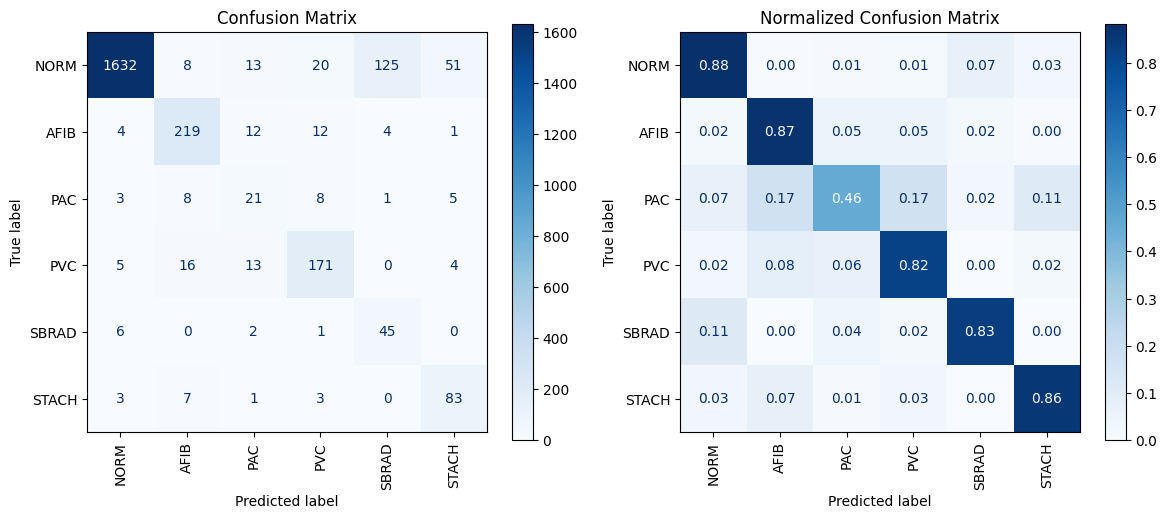

In [9]:
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)
class_names = ['NORM', 'AFIB', 'PAC', 'PVC', 'SBRAD', 'STACH']

# Normalize
cm_normalized = np.divide(
    cm.astype('float'),
    cm.sum(axis=1)[:, np.newaxis],
    out=np.zeros_like(cm, dtype=float),
    where=cm.sum(axis=1)[:, np.newaxis] != 0
)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Raw confusion matrix
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp1.plot(ax=ax1, cmap='Blues', xticks_rotation='vertical', colorbar=True)
ax1.set_title("Confusion Matrix")

# Normalized confusion matrix
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
disp2.plot(ax=ax2, cmap='Blues', xticks_rotation='vertical', values_format=".2f", colorbar=True)
ax2.set_title("Normalized Confusion Matrix")

plt.tight_layout()
plt.show()

ECGNet

In [ ]:
model = ECGNet().to(device)
model.load_state_dict(torch.load("./models/ECGNet_weightedLoss.pth"))
model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test = X_test.to(device)
        y_test = y_test.to(device)
        outputs = model(X_test)
        preds = torch.argmax(outputs, dim=1)
        test_preds.extend(preds.cpu().numpy())
        test_labels.extend(y_test.cpu().numpy())

print(classification_report(test_labels, test_preds, target_names=['NORM', 'AFIB', 'PAC', 'PVC', 'SBRAD', 'STACH']))

              precision    recall  f1-score   support

        NORM       0.98      0.93      0.95      1849
        AFIB       0.83      0.89      0.86       252
         PAC       0.44      0.37      0.40        46
         PVC       0.79      0.82      0.81       209
       SBRAD       0.43      0.63      0.51        54
       STACH       0.59      0.86      0.70        97

    accuracy                           0.90      2507
   macro avg       0.68      0.75      0.71      2507
weighted avg       0.91      0.90      0.90      2507



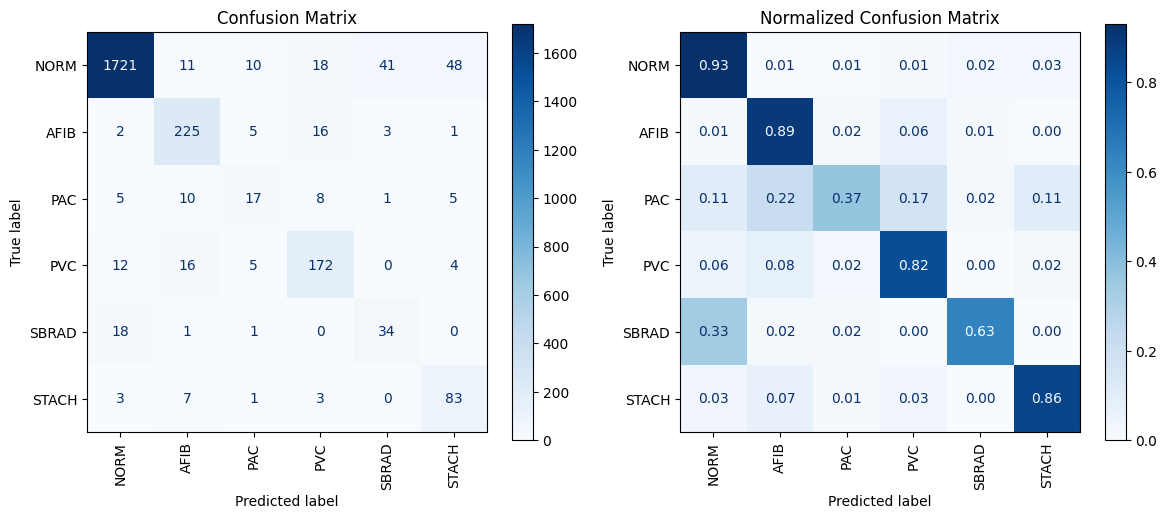

In [11]:
# Compute confusion matrix
cm = confusion_matrix(test_labels, test_preds)
class_names = ['NORM', 'AFIB', 'PAC', 'PVC', 'SBRAD', 'STACH']

# Normalize
cm_normalized = np.divide(
    cm.astype('float'),
    cm.sum(axis=1)[:, np.newaxis],
    out=np.zeros_like(cm, dtype=float),
    where=cm.sum(axis=1)[:, np.newaxis] != 0
)

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Raw confusion matrix
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp1.plot(ax=ax1, cmap='Blues', xticks_rotation='vertical', colorbar=True)
ax1.set_title("Confusion Matrix")

# Normalized confusion matrix
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
disp2.plot(ax=ax2, cmap='Blues', xticks_rotation='vertical', values_format=".2f", colorbar=True)
ax2.set_title("Normalized Confusion Matrix")

plt.tight_layout()
plt.show()